# Proyecto de Clasificación
Para este proyecto trabajarán con el dataset
[Heart Failure Prediction - Clinical Records](https://www.kaggle.com/datasets/aadarshvelu/heart-failure-prediction-clinical-records).
Toda la información sobre el dataset la pueden encontrar en el link. Aprender a
leer la información y entender cómo está construido un dataset es un *skill* muy
importante, que deben desarrollar.

Por otro lado, recuerden que Kaggle tiene una pestaña `Code`, donde pueden
inspeccionar código de otras personas; siéntanse libres de hacerlo, ese es otro
skill importante y es la forma en la que la mayoría de la gente en el campo
aprende sobre nuevos modelos y se mantiene actualizada.

Su proyecto deberá incluir:
- Descarga e importación del Dataset
- EDA: justificar por qué decidieron utilizar sus métodos de visualización,
además de proporcionar alguna breve conclusión que obtengan a partir de su
análisis de los datos
- Metodos de validación: Hold-out y k-fold
- Preproceso: justificar las operaciones realizadas
- Entrenamiento de modelos:
    - [kNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
    - [Regresión Logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
    - [Árboles de Decisión](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
    - [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
    - [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). **Recurso:** [Support Vector Machines](https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/)
    - Deberán trabajar con al menos dos modelos de los vistos en clase; el uso de
    SVM es **obligatorio**, investigar sobre un método nuevo y animarse a
    utilizar las implementaciones es, quizás, el *skill* más preciado que puedan
    desarrollar.
- Prueba y Desempeño del modelo
- Conclusiones


## Imports y variables globales

In [197]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

SEED = 73
np.random.seed(SEED)

file_path = 'heart_failure_clinical_records_dataset.csv'
# file_path = 'heart_failure_clinical_records_dataset_cleaned.csv'

In [198]:
# import data as array
ds_arr = np.loadtxt(file_path, delimiter=',', skiprows=1)

# import data as pandas dataframe  
ds_df = pd.read_csv(file_path)

ds_df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.30,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.00,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.90,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.20,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.00,132,1,0,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,75.0,0,582,1,30,1,263358.03,1.83,134,1,0,23,1
1316,73.0,0,582,0,20,0,263358.03,1.83,134,1,1,198,1
1317,45.0,0,220,0,35,0,174000.00,0.80,139,1,1,121,0
1318,40.0,1,129,1,35,0,255000.00,0.90,137,1,0,209,0


## EDA
- ¿Mi banco de datos es balanceado?, ¿Cómo puedo saberlo?
- ¿Qué otras visualizaciones puedo realizar para analizar mis datos?

### Descripción de los datos

Se obtienen algunas estadíticas del conjunto de datos, y se decide describir si los valores son **discretos** o **continuos**; si el número de valores únicos encontrados en cada columna es menor a **10**, se categoriza como valor **discreto**.

In [199]:
columns = ds_df.keys()

ds_desc = ds_df.describe().T
ds_desc.insert(1, 'values_type', None)
ds_desc.insert(2, 'unique_val_cnt', None)
ds_desc.insert(3, 'unique_values', None)


for column in columns:
    col_unique_data = ds_df[column].unique()
    col_unique_data.sort()
    col_type = 'continuous' if col_unique_data.size > 10  else 'discrete'

    ds_desc.at[column, 'values_type'] = col_type
    ds_desc.at[column, 'unique_val_cnt'] = col_unique_data.size
    ds_desc.at[column, 'unique_values'] = col_unique_data

# Exclude last column as it is the target
disc_cols = ds_desc.loc[ds_desc['values_type'] == 'discrete'][:-1]
cont_cols = ds_desc.loc[ds_desc['values_type'] == 'continuous']

ds_desc

,count,values_type,unique_val_cnt,unique_values,mean,std,min,25%,50%,75%,max
age,1320.0,continuous,48,"[40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47....",60.587377,11.913538,40.0,50.0,60.00,69.0,95.0
anaemia,1320.0,discrete,2,"[0, 1]",0.485606,0.499982,0.0,0.0,0.00,1.0,1.0
creatinine_phosphokinase,1320.0,continuous,290,"[23, 25, 26, 30, 31, 34, 44, 47, 52, 53, 54, 5...",576.135606,970.630878,23.0,115.0,249.00,582.0,7861.0
diabetes,1320.0,discrete,2,"[0, 1]",0.446970,0.497368,0.0,0.0,0.00,1.0,1.0
ejection_fraction,1320.0,continuous,17,"[14, 15, 17, 20, 25, 30, 35, 38, 40, 45, 50, 5...",37.881818,11.572547,14.0,30.0,38.00,45.0,80.0
high_blood_pressure,1320.0,discrete,2,"[0, 1]",0.369697,0.482906,0.0,0.0,0.00,1.0,1.0
platelets,1320.0,continuous,203,"[25100.0, 26000.0, 26500.0, 27000.0, 27100.0, ...",263751.982189,106345.010143,25100.0,208000.0,263358.03,310000.0,850000.0
serum_creatinine,1320.0,continuous,43,"[0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0, 1.0...",1.356447,0.998924,0.5,0.9,1.10,1.3,9.4
serum_sodium,1320.0,continuous,27,"[113, 116, 121, 124, 125, 126, 127, 128, 129, ...",136.665909,4.380990,113.0,134.0,137.00,140.0,148.0
sex,1320.0,discrete,2,"[0, 1]",0.645455,0.478557,0.0,0.0,1.00,1.0,1.0


### Balanceo de clases

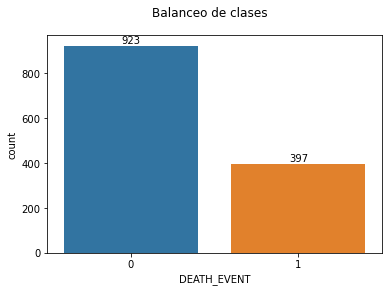

In [200]:
fig, ax = plt.subplots()

ax = sns.countplot(ds_df, x='DEATH_EVENT')

fig.suptitle('Balanceo de clases')
ax.bar_label(ax.containers[0])

plt.show()

**Conclusion:**

Al encontrar que hay dos clases, y el 68.64% de éstas presentan valor 0, podemos decir que es un conjunto de datos desbalanceado.

### Visualización de datos discretos

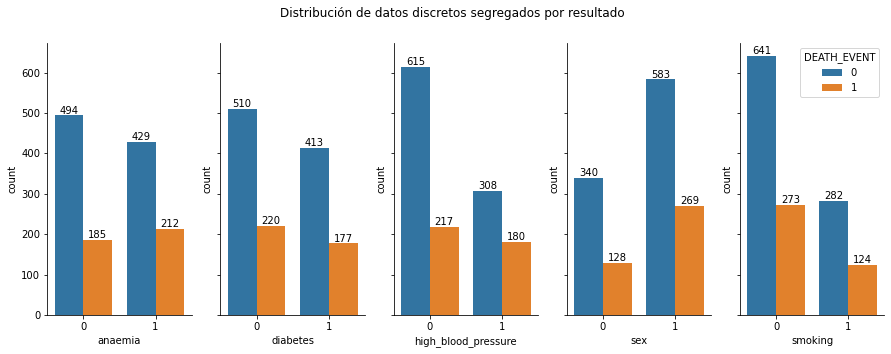

In [201]:
fig, axes = plt.subplots(ncols=disc_cols.index.values.size, sharey=True, figsize=(15,5))

idx = 0

for col in disc_cols.index:
    ax = axes[idx]
    sns.countplot(ds_df,
                  x=col,
                  hue='DEATH_EVENT',
                  ax=ax)

    if idx < axes.size - 1:
        ax.get_legend().remove()

    ax.spines[['right', 'top']].set_visible(False)
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    
    idx = idx + 1

fig.suptitle('Distribución de datos discretos segregados por resultado')

plt.show()

### Visualización de datos continuos

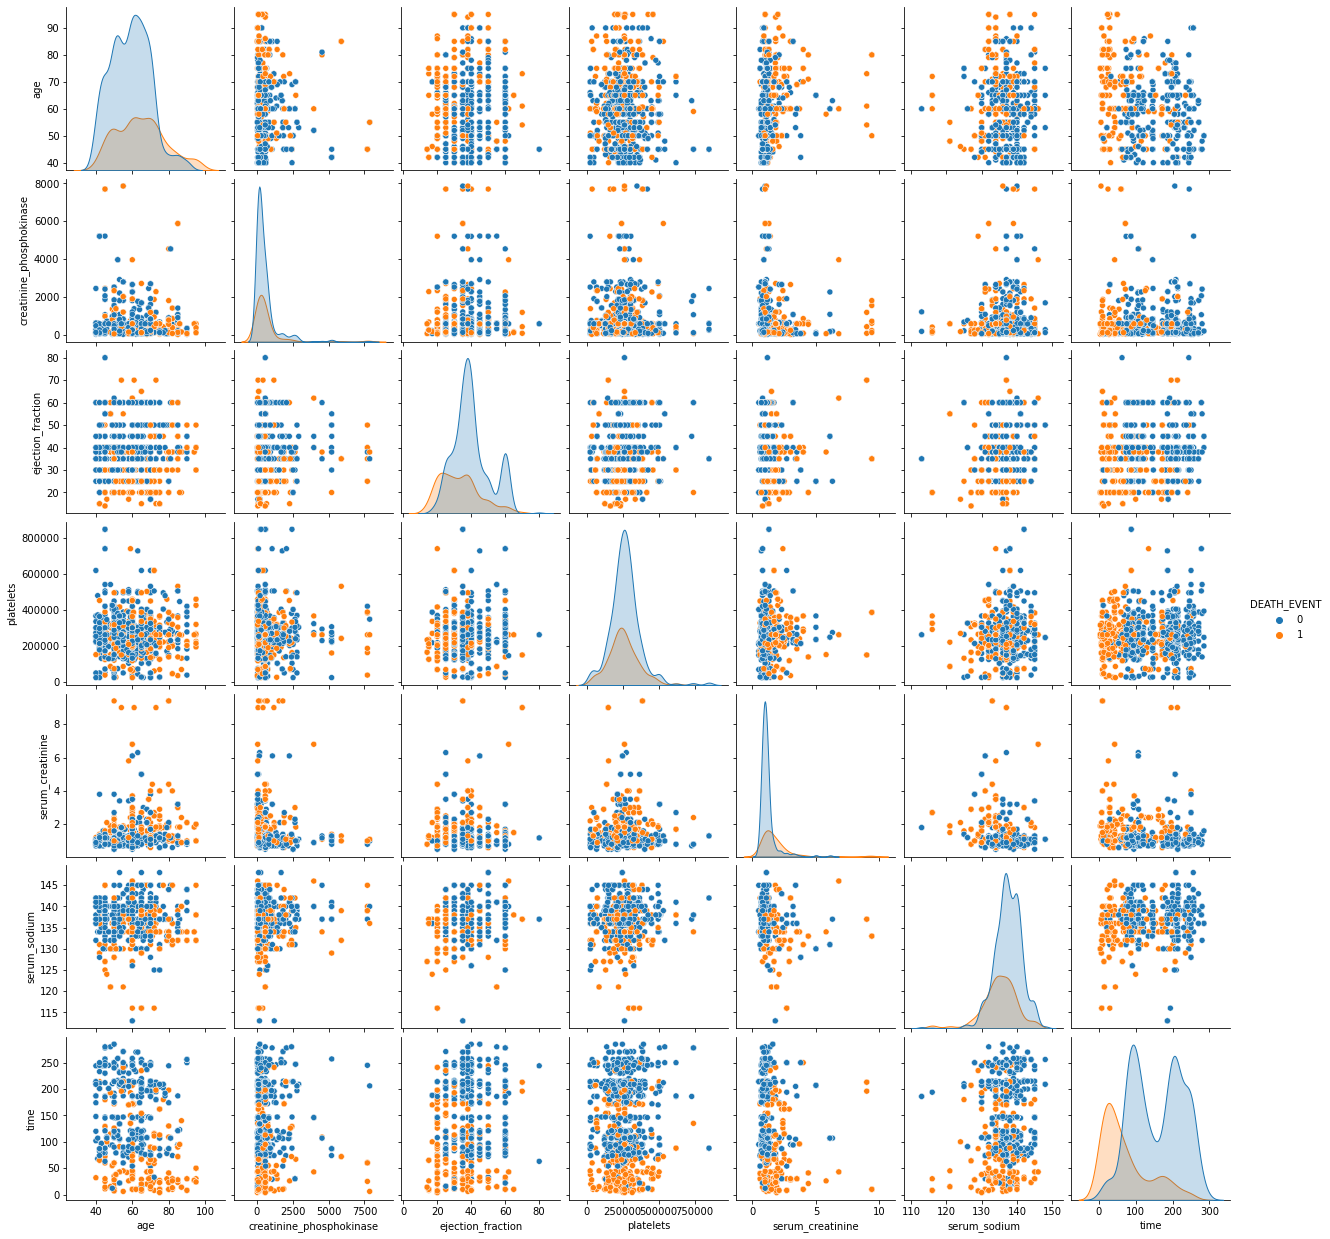

In [202]:
sns.pairplot(ds_df,
             hue='DEATH_EVENT',
             diag_kind='kde',
             vars=cont_cols.index)

plt.show()

### Correlación de datos

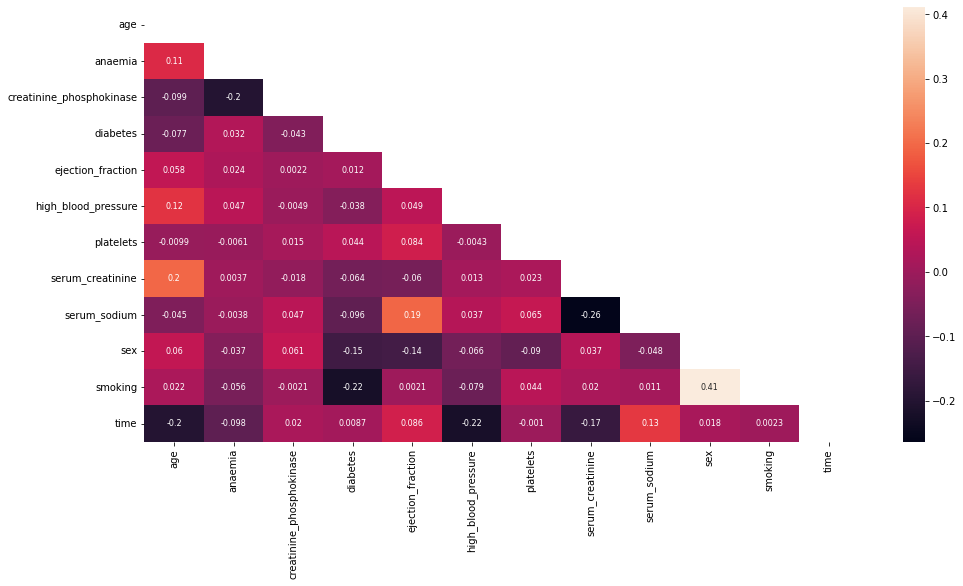

In [203]:
plt.figure(figsize=(16,8))

ds_corr = ds_df.drop(columns=['DEATH_EVENT']).corr()

sns.heatmap(ds_corr,
            annot=True,
            annot_kws={'size': 8,},
            mask=np.triu(np.ones_like(ds_corr.transpose())))

plt.show()

## Validación
Utilizar Hold-out y k-fold. En caso de que el dataset sea desbalanceado, debemos
de asegurar, en la medida de lo posible, que nuestras particiones respetarán la
distribución de nuestros datos, el término `stratified` en `sklearn` hace
referencia a este proceso.

- [hold-out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Si el dataset es desbalanceado, deberán utilizar el
parámetro `stratify`.
- [k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
- [Stratified k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

**Nota**: Recuerda que hold-out se ejecuta una sola vez, mientras que kfold se
ejecuta k número de veces (requieres un ciclo `for` para ello)

## Preproceso
- ¿Qué transformaciones debería hacer a mis datos?

## Prueba y desempeño del modelo
Para problemas balanceados, ya vimos como se prueba y se mide el desempeño del
modelo para ambos métodos de validación. Aunque `accuracy` es la métrica
predilecta, nada impide, si así lo desean, que calculen alguna otra métrica que
surja a partir de la matriz de confusión.

En el caso de datasets desbalanceados, lo primero que deben de recordar es que
`accuracy` **no es una métrica válida**, por lo que debemos recurrir a alguna
otra métrica y a nuestra `matriz de confusión`. Para el caso de `hold-out`,
basta con calcular el desempeño del modelo una vez ha sido entrenado y puesto a
prueba. Sin embargo, en el caso de `k-fold`, no podemos calcular las métricas
de desempeño del modelo en cada fold y luego promediar (cosa que hacemos cuando
es balanceado y calculamos accuracy); debemos almacenar todas las predicciones y
las ground truth de todos los folds (**conservando el orden en que fueron
presentados al modelo**), y una vez que terminamos con los folds, debemos
calcular la métrica de manera global.




A continuación se les proporciona un repaso de
[la matriz de confusión y métricas de desempeño](https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/).

Las métricas ya forman parte de `sklearn`:
- [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Balanced Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)
- [Recall (sensitivity)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
- [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)


Veamos un caso de `k-fold` con datos desbalanceados y calculo de diferentes
métricas. Solo crearemos un vector síntetico de ground truth, y en cada fold
crearemos un vector de *predicciones* de manera aleatoria.

## Entrenamiento del modelo
Utilizar al menos dos algoritmos de clase, además del clasificador de Máquinas
de Soporte Vectorial.

In [204]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, \
                            balanced_accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

def scale(scaler, X_train, X_test):
    scaler.fit(X_train)

    scaled_X_train = scaler.transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    return (scaled_X_train, scaled_X_test)


def train(model , model_name, X_train, X_test, y_train):
    print(f'Train using {model_name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def get_conf_matrix_report(model_name, y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))

    _, ax = plt.subplots(figsize=(20, 6))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt="d", cmap="Blues", linewidths=.5)

    ax.set_title(f'Confusion Matrix for {model_name} classifier')

    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(f'{model_name} True Negative: {tn}')
    print(f'{model_name} False Positive: {fp}')
    print(f'{model_name} False Negative: {fn}')
    print(f'{model_name} True Positive: {tp}')
    print()

    recall_own = tp / (tp + fn)
    recall_sk = recall_score(y_test, y_pred)
    print(f"{model_name} Recall own: {recall_own}")
    print(f"{model_name} Recall sk: {recall_sk}")
    print(f"{model_name} Recall own == Recall sk: {recall_own == recall_sk}")
    print()

    # precision
    precision_own = tp / (tp + fp)
    precision_sk = precision_score(y_test, y_pred)
    print(f"{model_name} Precision own: {precision_own}")
    print(f"{model_name} Precision sk: {precision_sk}")
    print(f"{model_name} Precision own == Recall sk: {precision_own == precision_sk}")
    print()

    # specificity no está programa, pero es un recall de la clase 0
    specificity_own = tn / (tn + fp)
    specificity_sk = recall_score(y_test, y_pred, pos_label=0)
    print(f"{model_name} Specificity own: {specificity_own}")
    print(f"{model_name} Specificity sk: {specificity_sk}")
    print(f"{model_name} Specificity own == Recall sk: {specificity_own == specificity_sk}")
    print()

    # balanced accuracy
    balanced_accuracy_own = (recall_own + specificity_own) / 2
    balanced_accuracy_sk = balanced_accuracy_score(y_test, y_pred)
    print(f"{model_name} Balanced Accuracy own: {balanced_accuracy_own}")
    print(f"{model_name} Balanced Accuracy sk: {balanced_accuracy_sk}")
    print(f"{model_name} Balanced Accuracy own == Recall sk: {balanced_accuracy_own == balanced_accuracy_sk}")
    print()

### Hold Out

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = ds_df.drop(columns=['DEATH_EVENT']).to_numpy()
y = ds_df['DEATH_EVENT'].to_numpy()

ho_X_train, ho_X_test, ho_y_train, ho_y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

Se aplica la normalización de datos, para mantener los valores en rangos similares.

In [206]:
from sklearn.preprocessing import StandardScaler

ho_X_train_std, ho_X_test_std = scale(StandardScaler(), 
                                      ho_X_train, 
                                      ho_X_test)

#### Entrenamiento y resultados con clasificador KNeighborsClassifier

Train using KNeighborsClassifier
[[175  10]
 [ 30  49]]


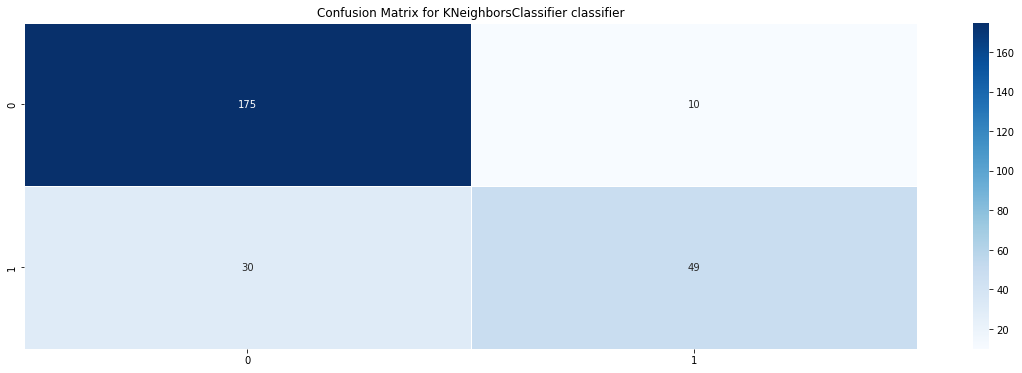

KNeighborsClassifier True Negative: 175
KNeighborsClassifier False Positive: 10
KNeighborsClassifier False Negative: 30
KNeighborsClassifier True Positive: 49

KNeighborsClassifier Recall own: 0.620253164556962
KNeighborsClassifier Recall sk: 0.620253164556962
KNeighborsClassifier Recall own == Recall sk: True

KNeighborsClassifier Precision own: 0.8305084745762712
KNeighborsClassifier Precision sk: 0.8305084745762712
KNeighborsClassifier Precision own == Recall sk: True

KNeighborsClassifier Specificity own: 0.9459459459459459
KNeighborsClassifier Specificity sk: 0.9459459459459459
KNeighborsClassifier Specificity own == Recall sk: True

KNeighborsClassifier Balanced Accuracy own: 0.7830995552514539
KNeighborsClassifier Balanced Accuracy sk: 0.7830995552514539
KNeighborsClassifier Balanced Accuracy own == Recall sk: True



In [207]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 3

knn = KNeighborsClassifier(n_neighbors=n_neighbors)

knn_ho_y_pred_std = train(knn, 'KNeighborsClassifier', ho_X_train_std, ho_X_test_std, ho_y_train)

get_conf_matrix_report('KNeighborsClassifier', ho_y_test, knn_ho_y_pred_std)

#### Entrenamiento y resultados con clasificador SVC

Train using SVC kernel RBF
[[176   9]
 [ 20  59]]


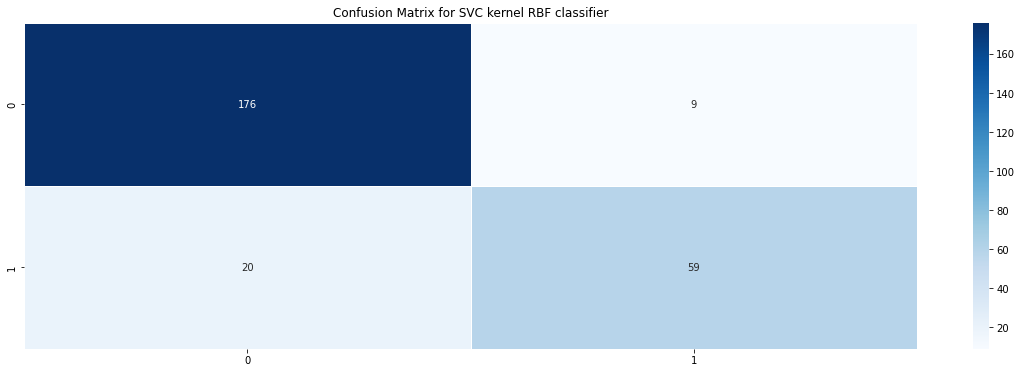

SVC kernel RBF True Negative: 176
SVC kernel RBF False Positive: 9
SVC kernel RBF False Negative: 20
SVC kernel RBF True Positive: 59

SVC kernel RBF Recall own: 0.7468354430379747
SVC kernel RBF Recall sk: 0.7468354430379747
SVC kernel RBF Recall own == Recall sk: True

SVC kernel RBF Precision own: 0.8676470588235294
SVC kernel RBF Precision sk: 0.8676470588235294
SVC kernel RBF Precision own == Recall sk: True

SVC kernel RBF Specificity own: 0.9513513513513514
SVC kernel RBF Specificity sk: 0.9513513513513514
SVC kernel RBF Specificity own == Recall sk: True

SVC kernel RBF Balanced Accuracy own: 0.849093397194663
SVC kernel RBF Balanced Accuracy sk: 0.849093397194663
SVC kernel RBF Balanced Accuracy own == Recall sk: True



In [208]:
from sklearn import svm

rbf = svm.SVC(kernel='rbf', random_state=SEED)

rbf_ho_y_pred_std = train(rbf, 'SVC kernel RBF', ho_X_train_std, ho_X_test_std, ho_y_train)

get_conf_matrix_report('SVC kernel RBF', ho_y_test, rbf_ho_y_pred_std)

#### Entrenamiento y resultados con clasificador Decision Tree

Train using Decision Tree Classifier
[[176   9]
 [  4  75]]


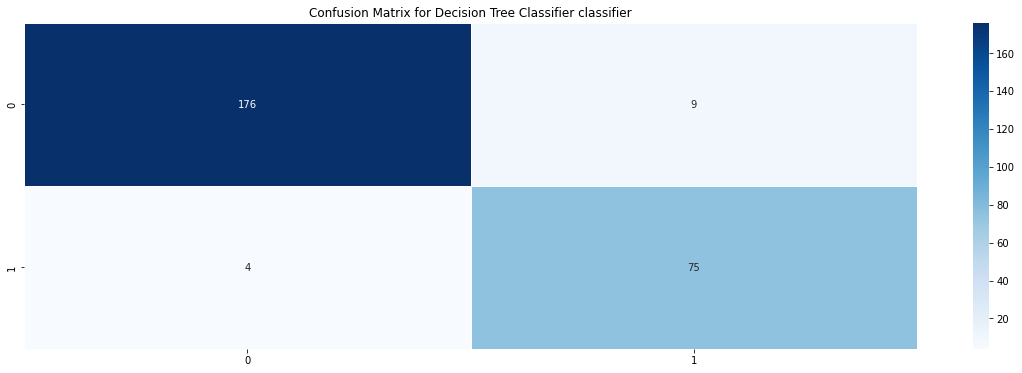

Decision Tree Classifier True Negative: 176
Decision Tree Classifier False Positive: 9
Decision Tree Classifier False Negative: 4
Decision Tree Classifier True Positive: 75

Decision Tree Classifier Recall own: 0.9493670886075949
Decision Tree Classifier Recall sk: 0.9493670886075949
Decision Tree Classifier Recall own == Recall sk: True

Decision Tree Classifier Precision own: 0.8928571428571429
Decision Tree Classifier Precision sk: 0.8928571428571429
Decision Tree Classifier Precision own == Recall sk: True

Decision Tree Classifier Specificity own: 0.9513513513513514
Decision Tree Classifier Specificity sk: 0.9513513513513514
Decision Tree Classifier Specificity own == Recall sk: True

Decision Tree Classifier Balanced Accuracy own: 0.9503592199794731
Decision Tree Classifier Balanced Accuracy sk: 0.9503592199794731
Decision Tree Classifier Balanced Accuracy own == Recall sk: True



In [209]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=10, random_state=SEED)

dtc_ho_y_pred_std = train(dtc, 'Decision Tree Classifier', ho_X_train_std, ho_X_test_std, ho_y_train)

get_conf_matrix_report('Decision Tree Classifier', ho_y_test, dtc_ho_y_pred_std)

### Stratified K Fold

In [210]:
from sklearn.model_selection import StratifiedKFold

folds = dict()

splits = 5

skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):    
    folds[i] = (train_index, test_index)

Se aplica normalización por fold

In [211]:
folds_std = dict()

for k in folds.keys():
    # Fold Normalization
    # print(f'Fold {k}')
    train_index, test_index = folds[k]

    skf_X_train = X[train_index]
    skf_y_train = y[train_index]
    skf_X_test = X[test_index]
    skf_y_test = y[test_index]

    skf_X_train_std, skf_X_test_std = scale(StandardScaler(), 
                                            skf_X_train, 
                                            skf_X_test)

    folds_std[k] = skf_X_train_std, skf_X_test_std



#### Entrenamiento y resultados con clasificador KNeighborsClassifier

Train using KNeighborsClassifier Fold 0
Train using KNeighborsClassifier Fold 1
Train using KNeighborsClassifier Fold 2
Train using KNeighborsClassifier Fold 3
Train using KNeighborsClassifier Fold 4
---------- Resultados ----------
Balanced accuracy avg: 0.5514673913043479
Balanced accuracy global: 0.5514673913043477

F1 avg: 0.33011914113642316
F1 global: 0.340974212034384

Recall avg: 0.2975
Recall global: 0.2975
[[741 179]
 [281 119]]


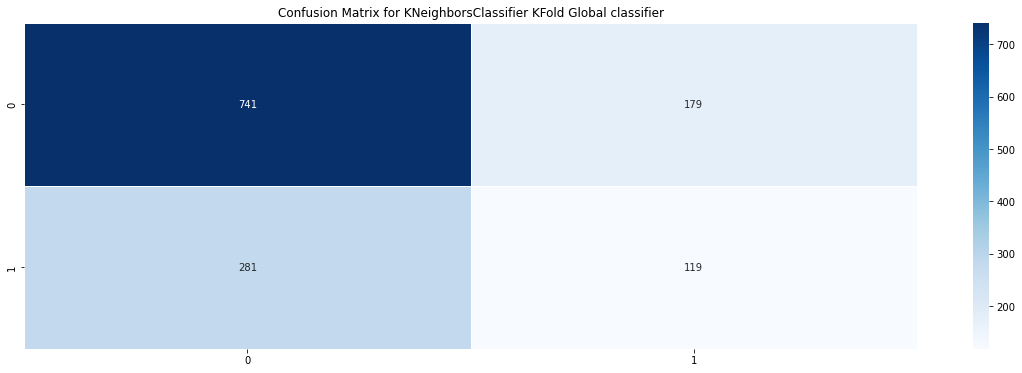

KNeighborsClassifier KFold Global True Negative: 741
KNeighborsClassifier KFold Global False Positive: 179
KNeighborsClassifier KFold Global False Negative: 281
KNeighborsClassifier KFold Global True Positive: 119

KNeighborsClassifier KFold Global Recall own: 0.2975
KNeighborsClassifier KFold Global Recall sk: 0.2975
KNeighborsClassifier KFold Global Recall own == Recall sk: True

KNeighborsClassifier KFold Global Precision own: 0.39932885906040266
KNeighborsClassifier KFold Global Precision sk: 0.39932885906040266
KNeighborsClassifier KFold Global Precision own == Recall sk: True

KNeighborsClassifier KFold Global Specificity own: 0.8054347826086956
KNeighborsClassifier KFold Global Specificity sk: 0.8054347826086956
KNeighborsClassifier KFold Global Specificity own == Recall sk: True

KNeighborsClassifier KFold Global Balanced Accuracy own: 0.5514673913043477
KNeighborsClassifier KFold Global Balanced Accuracy sk: 0.5514673913043477
KNeighborsClassifier KFold Global Balanced Accurac

In [212]:
knn_balanced_accuracy_avg = 0
knn_f1_avg = 0
knn_recall_avg = 0
knn_skf_y_preds = []
knn_skf_ys = []

for k in folds.keys():
    # print(f'Fold {k} results')
    skf_y_train = y[train_index]
    skf_y_test = y[test_index]
    skf_X_train_std, skf_X_test_std = folds_std[k]

    knn_skf_y_preds_std = train(knn, f'KNeighborsClassifier Fold {k}', skf_X_train_std, skf_X_test_std, skf_y_train)

    knn_skf_y_preds += list(knn_skf_y_preds_std)
    knn_skf_ys += list(skf_y_test)

    knn_balanced_accuracy_avg += balanced_accuracy_score(skf_y_test, knn_skf_y_preds_std)
    knn_f1_avg += f1_score(skf_y_test, knn_skf_y_preds_std)
    knn_recall_avg += recall_score(skf_y_test, knn_skf_y_preds_std)

    # get_conf_matrix_report(f'KNeighborsClassifier Fold {k}', skf_y_test, knn_skf_y_preds_std)

print(10*'-' + ' Resultados ' + 10*'-')
print(f"Balanced accuracy avg: {knn_balanced_accuracy_avg/splits}")
print(f"Balanced accuracy global: {balanced_accuracy_score(knn_skf_ys, knn_skf_y_preds)}")
print()
print(f"F1 avg: {knn_f1_avg/splits}")
print(f"F1 global: {f1_score(knn_skf_ys, knn_skf_y_preds)}")
print()
print(f"Recall avg: {knn_recall_avg/splits}")
print(f"Recall global: {recall_score(knn_skf_ys, knn_skf_y_preds)}")

get_conf_matrix_report('KNeighborsClassifier KFold Global', knn_skf_ys, knn_skf_y_preds)

#### Entrenamiento y resultados con clasificador SVC

Train using SVC kernel RBF Fold 0
Train using SVC kernel RBF Fold 1
Train using SVC kernel RBF Fold 2
Train using SVC kernel RBF Fold 3
Train using SVC kernel RBF Fold 4
---------- Resultados ----------
Balanced accuracy avg: 0.5726086956521739
Balanced accuracy global: 0.5726086956521739

F1 avg: 0.16869666086668322
F1 global: 0.26326963906581735

Recall avg: 0.15499999999999997
Recall global: 0.155
[[911   9]
 [338  62]]


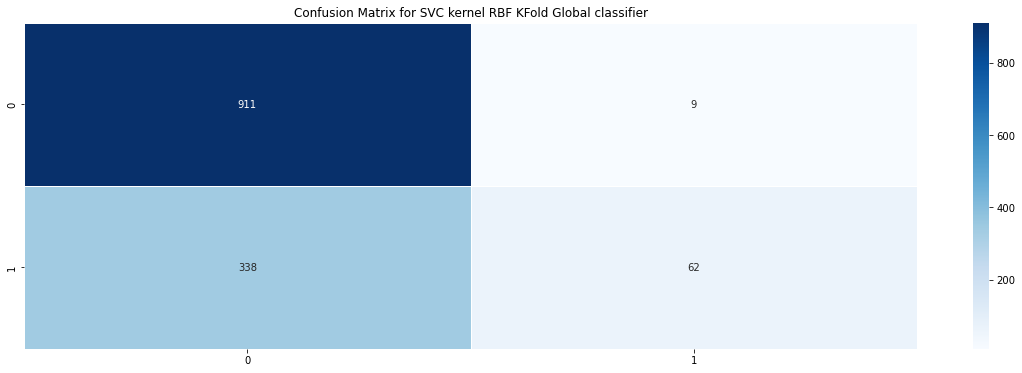

SVC kernel RBF KFold Global True Negative: 911
SVC kernel RBF KFold Global False Positive: 9
SVC kernel RBF KFold Global False Negative: 338
SVC kernel RBF KFold Global True Positive: 62

SVC kernel RBF KFold Global Recall own: 0.155
SVC kernel RBF KFold Global Recall sk: 0.155
SVC kernel RBF KFold Global Recall own == Recall sk: True

SVC kernel RBF KFold Global Precision own: 0.8732394366197183
SVC kernel RBF KFold Global Precision sk: 0.8732394366197183
SVC kernel RBF KFold Global Precision own == Recall sk: True

SVC kernel RBF KFold Global Specificity own: 0.9902173913043478
SVC kernel RBF KFold Global Specificity sk: 0.9902173913043478
SVC kernel RBF KFold Global Specificity own == Recall sk: True

SVC kernel RBF KFold Global Balanced Accuracy own: 0.5726086956521739
SVC kernel RBF KFold Global Balanced Accuracy sk: 0.5726086956521739
SVC kernel RBF KFold Global Balanced Accuracy own == Recall sk: True



In [213]:
rbf_balanced_accuracy_avg = 0
rbf_f1_avg = 0
rbf_recall_avg = 0
rbf_skf_y_preds = []
rbf_skf_ys = []

for k in folds.keys():
    # print(f'Fold {k} results')
    skf_y_train = y[train_index]
    skf_y_test = y[test_index]
    skf_X_train_std, skf_X_test_std = folds_std[k]

    rbf_skf_y_preds_std = train(rbf, f'SVC kernel RBF Fold {k}', skf_X_train_std, skf_X_test_std, skf_y_train)

    rbf_skf_y_preds += list(rbf_skf_y_preds_std)
    rbf_skf_ys += list(skf_y_test)

    rbf_balanced_accuracy_avg += balanced_accuracy_score(skf_y_test, rbf_skf_y_preds_std)
    rbf_f1_avg += f1_score(skf_y_test, rbf_skf_y_preds_std)
    rbf_recall_avg += recall_score(skf_y_test, rbf_skf_y_preds_std)

    # get_conf_matrix_report(f'SVC kernel RBF Fold {k}', skf_y_test, rbf_skf_y_preds_std)

print(10*'-' + ' Resultados ' + 10*'-')
print(f"Balanced accuracy avg: {rbf_balanced_accuracy_avg/splits}")
print(f"Balanced accuracy global: {balanced_accuracy_score(rbf_skf_ys, rbf_skf_y_preds)}")
print()
print(f"F1 avg: {rbf_f1_avg/splits}")
print(f"F1 global: {f1_score(rbf_skf_ys, rbf_skf_y_preds)}")
print()
print(f"Recall avg: {rbf_recall_avg/splits}")
print(f"Recall global: {recall_score(rbf_skf_ys, rbf_skf_y_preds)}")
get_conf_matrix_report('SVC kernel RBF KFold Global', rbf_skf_ys, rbf_skf_y_preds)

#### Entrenamiento y resultados con clasificador Decision Tree

Train using DecisionTreeClassifier Fold 0
Train using DecisionTreeClassifier Fold 1
Train using DecisionTreeClassifier Fold 2
Train using DecisionTreeClassifier Fold 3
Train using DecisionTreeClassifier Fold 4
---------- Resultados ----------
Balanced accuracy avg: 0.5805978260869565
Balanced accuracy global: 0.5805978260869565

F1 avg: 0.33935280650210115
F1 global: 0.37173579109062976

Recall avg: 0.3025
Recall global: 0.3025
[[790 130]
 [279 121]]


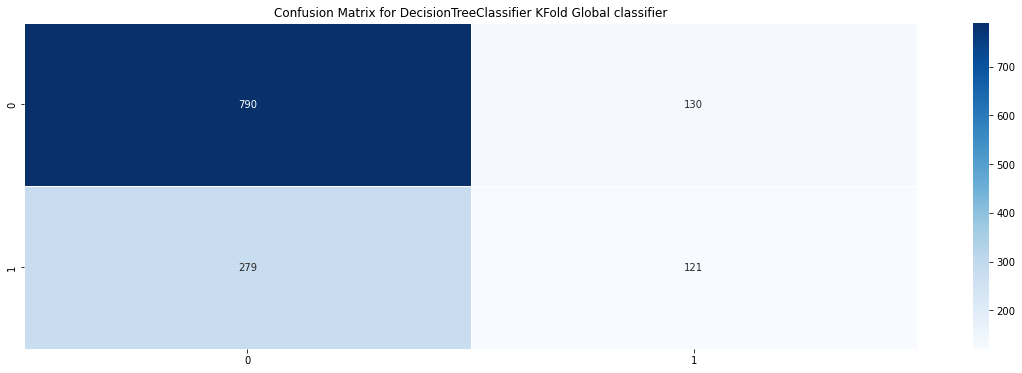

DecisionTreeClassifier KFold Global True Negative: 790
DecisionTreeClassifier KFold Global False Positive: 130
DecisionTreeClassifier KFold Global False Negative: 279
DecisionTreeClassifier KFold Global True Positive: 121

DecisionTreeClassifier KFold Global Recall own: 0.3025
DecisionTreeClassifier KFold Global Recall sk: 0.3025
DecisionTreeClassifier KFold Global Recall own == Recall sk: True

DecisionTreeClassifier KFold Global Precision own: 0.4820717131474104
DecisionTreeClassifier KFold Global Precision sk: 0.4820717131474104
DecisionTreeClassifier KFold Global Precision own == Recall sk: True

DecisionTreeClassifier KFold Global Specificity own: 0.8586956521739131
DecisionTreeClassifier KFold Global Specificity sk: 0.8586956521739131
DecisionTreeClassifier KFold Global Specificity own == Recall sk: True

DecisionTreeClassifier KFold Global Balanced Accuracy own: 0.5805978260869565
DecisionTreeClassifier KFold Global Balanced Accuracy sk: 0.5805978260869565
DecisionTreeClassifier

In [214]:
dtc_balanced_accuracy_avg = 0
dtc_f1_avg = 0
dtc_recall_avg = 0
dtc_skf_y_preds = []
dtc_skf_ys = []

for k in folds.keys():
    # print(f'Fold {k} results')
    skf_y_train = y[train_index]
    skf_y_test = y[test_index]
    skf_X_train_std, skf_X_test_std = folds_std[k]

    dtc_skf_y_preds_std = train(dtc, f'DecisionTreeClassifier Fold {k}', skf_X_train_std, skf_X_test_std, skf_y_train)

    dtc_skf_y_preds += list(dtc_skf_y_preds_std)
    dtc_skf_ys += list(skf_y_test)

    dtc_balanced_accuracy_avg += balanced_accuracy_score(skf_y_test, dtc_skf_y_preds_std)
    dtc_f1_avg += f1_score(skf_y_test, dtc_skf_y_preds_std)
    dtc_recall_avg += recall_score(skf_y_test, dtc_skf_y_preds_std)

    # get_conf_matrix_report(f'SVC kernel RBF Fold {k}', skf_y_test, dtc_skf_y_preds_std)

print(10*'-' + ' Resultados ' + 10*'-')
print(f"Balanced accuracy avg: {dtc_balanced_accuracy_avg/splits}")
print(f"Balanced accuracy global: {balanced_accuracy_score(dtc_skf_ys, dtc_skf_y_preds)}")
print()
print(f"F1 avg: {dtc_f1_avg/splits}")
print(f"F1 global: {f1_score(dtc_skf_ys, dtc_skf_y_preds)}")
print()
print(f"Recall avg: {dtc_recall_avg/splits}")
print(f"Recall global: {recall_score(dtc_skf_ys, dtc_skf_y_preds)}")
get_conf_matrix_report('DecisionTreeClassifier KFold Global', dtc_skf_ys, dtc_skf_y_preds)

## Conclusiones

No me queda claro si hay algo incorrecto en mi procesamiento con Stratified KFold o si hay alguna circunstancia que haya provocado resultados tan malos, comparados con Hold Out.

Además, se observó que hay muchos datos repetidos y quizas esto influye en los datos consistentes de Hold Out. Para observar como afecta, se decidió crear el archivo (heart_failure_clinical_records_dataset_cleaned.csv)[lesson-3/heart_failure_clinical_records_dataset_cleaned.csv] donde se excluyen los datos que aparentemente están duplicados.
